In [2]:
import sys, os

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support


import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sn

In [3]:
data = pd.read_csv('clean_bo3_tdrive.csv', encoding='utf-8', converters={'p_start':eval,'p_temp':eval,'p_end':eval}, index_col=0)
data = data.drop(columns=['pre_routes','freq', 'pre_regions'])
data.reset_index(level=0, inplace=True)
data

,vehicle_id,p_start,p_temp,p_end,label
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)",False
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)",False
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)",False
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)",False
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)",False
...,...,...,...,...,...
7151,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.37373, 39.96672)",True
7152,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.29485, 39.95866)",True
7153,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.28478, 39.95682)",True
7154,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.31725, 39.95593)",True


In [4]:
data['label'] = data['label'].apply(lambda label: -1 if label == False else 1)

print("N_normal: ",len(data[data['label']==-1]))
print("N_abnormal: ",len(data[data['label']==1]))
data['label'].describe()

N_normal:  3805
N_abnormal:  3351


count    7156.000000
mean       -0.063443
std         0.998055
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [6]:
data['feature'] = data['p_start'] + data['p_temp'] + data['p_end']
data

,vehicle_id,p_start,p_temp,p_end,label,feature
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)",-1,"(116.76038, 39.79758, 116.7666, 39.8027, 116.7..."
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)",-1,"(116.76038, 39.79758, 116.7666, 39.8027, 116.7..."
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)",-1,"(116.76038, 39.79758, 116.7666, 39.8027, 116.7..."
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)",-1,"(116.76038, 39.79758, 116.7666, 39.8027, 116.7..."
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)",-1,"(116.76038, 39.79758, 116.7666, 39.8027, 116.6..."
...,...,...,...,...,...,...
7151,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.37373, 39.96672)",1,"(116.31534, 39.96547, 116.34378, 39.96626, 116..."
7152,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.29485, 39.95866)",1,"(116.31534, 39.96547, 116.34378, 39.96626, 116..."
7153,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.28478, 39.95682)",1,"(116.34378, 39.96626, 116.37373, 39.96672, 116..."
7154,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.31725, 39.95593)",1,"(116.34378, 39.96626, 116.37373, 39.96672, 116..."


In [7]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling

X = np.array(data['feature'].tolist())
y = np.array(data['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
vectorizer.fit(X_train)

X_train.shape, X_test.shape, len(vectorizer.get_feature_names())

d:\pythonapp\v2\.envgps-v2\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((5367, 6), (1789, 6), 812)

In [8]:
initial_idx = np.random.choice(range(len(X_train)), size=int(X_train.shape[0]*0.6), replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)



precision_test = []
recall_test = []
f1_test = []
acc_test = []

X_initial_mat = vectorizer.transform(X_initial)
X_pool_mat = vectorizer.transform(X_pool)
X_test_mat = vectorizer.transform(X_test)


n_initial = 100
n_queries = 50
clf = SVC(C=1.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)


learner = ActiveLearner(
    estimator=clf,
    query_strategy=entropy_sampling,
    X_training=X_initial_mat, y_training=y_initial
)

print(X_initial.shape, X_pool.shape, X_test.shape)

(3220, 6) (2147, 6) (1789, 6)


In [9]:
for i in range(n_queries):
#     print(X_pool_mat.shape)
    try:
        query_idx, query_instance = learner.query(X_pool_mat, n_instances=int(X_pool_mat.shape[0]/n_queries)+1)
    except:
        break

    y_new = y_pool[query_idx]
    learner.teach(X_pool_mat[query_idx], y_new)
    
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    X_pool_mat = vectorizer.transform(X_pool)
    
    y_pred = learner.predict(X_test_mat)

    precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred,average='macro')
    precision_test.append(precision)
    recall_test.append(recall)
    f1_test.append(fscore)
    acc_test.append(accuracy_score(y_test,y_pred))
    
    print('F1-score after query {n}: {acc:0.4f}'.format(n=i + 1, acc=f1_test[i]))


    
mean_precision_test = np.mean(precision_test)
mean_recall_test = np.mean(recall_test)
mean_f1_test = np.mean(f1_test)
mean_acc_test = np.mean(acc_test)

test_perfm = [mean_precision_test, mean_recall_test, mean_f1_test, mean_acc_test]

performance = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test'])
performance

F1-score after query 1: 0.9540
F1-score after query 2: 0.9602
F1-score after query 3: 0.9635
F1-score after query 4: 0.9618
F1-score after query 5: 0.9607
F1-score after query 6: 0.9613
F1-score after query 7: 0.9596
F1-score after query 8: 0.9607
F1-score after query 9: 0.9607
F1-score after query 10: 0.9607
F1-score after query 11: 0.9607
F1-score after query 12: 0.9601
F1-score after query 13: 0.9596
F1-score after query 14: 0.9596
F1-score after query 15: 0.9596
F1-score after query 16: 0.9596
F1-score after query 17: 0.9596
F1-score after query 18: 0.9601
F1-score after query 19: 0.9601
F1-score after query 20: 0.9601
F1-score after query 21: 0.9601
F1-score after query 22: 0.9601
F1-score after query 23: 0.9601
F1-score after query 24: 0.9601
F1-score after query 25: 0.9601
F1-score after query 26: 0.9601
F1-score after query 27: 0.9601
F1-score after query 28: 0.9601
F1-score after query 29: 0.9601
F1-score after query 30: 0.9601
F1-score after query 31: 0.9601
F1-score after qu

,precision,recall,f1-score,accuracy
test,0.959813,0.960472,0.960113,0.960291


In [10]:
test_perfm = [precision_test[-1], recall_test[-1], f1_test[-1], acc_test[-1]]
test_perfm_al = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_al'])
test_perfm_al

,precision,recall,f1-score,accuracy
test_al,0.959309,0.959868,0.959569,0.959754


In [11]:
X_train_mat = vectorizer.transform(X_train)
X_test_mat = vectorizer.transform(X_test)

clf = SVC(C=1.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)
clf.fit(X_train_mat, y_train)

y_pred_ml = clf.predict(X_test_mat)
ml_precision, ml_recall, ml_fscore, ml_support = precision_recall_fscore_support(y_test,y_pred_ml,average='macro')

ml_acc = accuracy_score(y_test,y_pred_ml)
test_perfm_ml = pd.DataFrame([[ml_precision,ml_recall,ml_fscore, ml_acc]], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_ml'])
test_perfm_ml

,precision,recall,f1-score,accuracy
test_ml,0.959309,0.959868,0.959569,0.959754


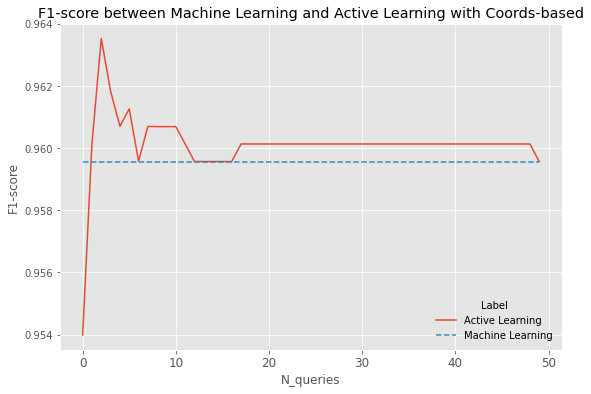

In [12]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.rcParams['xtick.labelsize'] = 12
plt.plot(range(len(f1_test)),f1_test, label='Active Learning')
plt.plot(range(len(f1_test)),[ml_fscore]*n_queries, '--',label='Machine Learning')
plt.xlabel('N_queries')
plt.ylabel('F1-score')
plt.legend(loc="lower right", title="Label", frameon=False)
plt.title("F1-score between Machine Learning and Active Learning with Coords-based")
plt.show()